# 🔍 SHAP Analysis on Energy Price Model

This notebook explains how the trained XGBoost model makes predictions
for energy prices using **SHAP (SHapley Additive exPlanations)**.

In [2]:
!pip install shap

   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.2 kB ? eta -:--:--
   ------------------------------------ - 524.3/545.2 kB 985.5 kB/s eta 0:00:01
   -------------------------------------- 545.2/545.2 kB 953.1 kB/s eta 0:00:00


In [3]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

## 📦 Load Data & Train Model (if needed)

In [4]:
# Load processed dataset
df = pd.read_csv('../data/processed/merged_energy_data_final_step_1.csv', parse_dates=['utc_timestamp'])
df.set_index('utc_timestamp', inplace=True)
df = df.sort_index()

# Feature engineering (if not already done)
df['price_lag_1h'] = df['Price (EUR/MWhe)'].shift(1)
df['price_lag_24h'] = df['Price (EUR/MWhe)'].shift(24)
df['price_lag_168h'] = df['Price (EUR/MWhe)'].shift(168)
df['price_roll_24h'] = df['Price (EUR/MWhe)'].rolling(24).mean()
df['price_roll_168h'] = df['Price (EUR/MWhe)'].rolling(168).mean()
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['solar_load_ratio'] = df['DE_solar_generation_actual'] / df['DE_load_actual_entsoe_transparency']
df['wind_load_ratio'] = df['DE_wind_generation_actual'] / df['DE_load_actual_entsoe_transparency']

# Final features used in model
features = [
    'DE_solar_generation_actual', 'DE_wind_generation_actual', 'DE_load_actual_entsoe_transparency',
    'Gas_Price', 'Oil_Price', 'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal',
    'DE_temperature',
    'price_lag_1h', 'price_lag_24h', 'price_lag_168h',
    'price_roll_24h', 'price_roll_168h',
    'hour', 'dayofweek', 'month',
    'solar_load_ratio', 'wind_load_ratio'
]

df_model = df[features + ['Price (EUR/MWhe)']].dropna()
X = df_model[features]
y = df_model['Price (EUR/MWhe)']

# Train model (or reuse existing)
model = XGBRegressor(n_estimators=100)
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

## 🔍 Global SHAP Summary

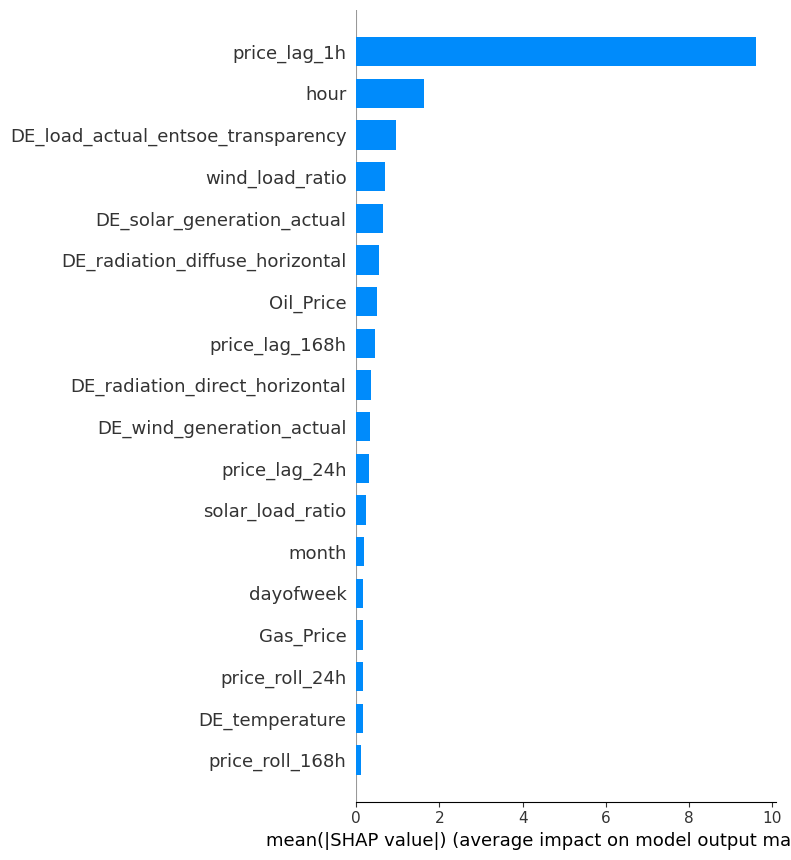

In [5]:
# Use TreeExplainer for XGBoost
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot (global importance)
shap.summary_plot(shap_values, X, plot_type='bar')

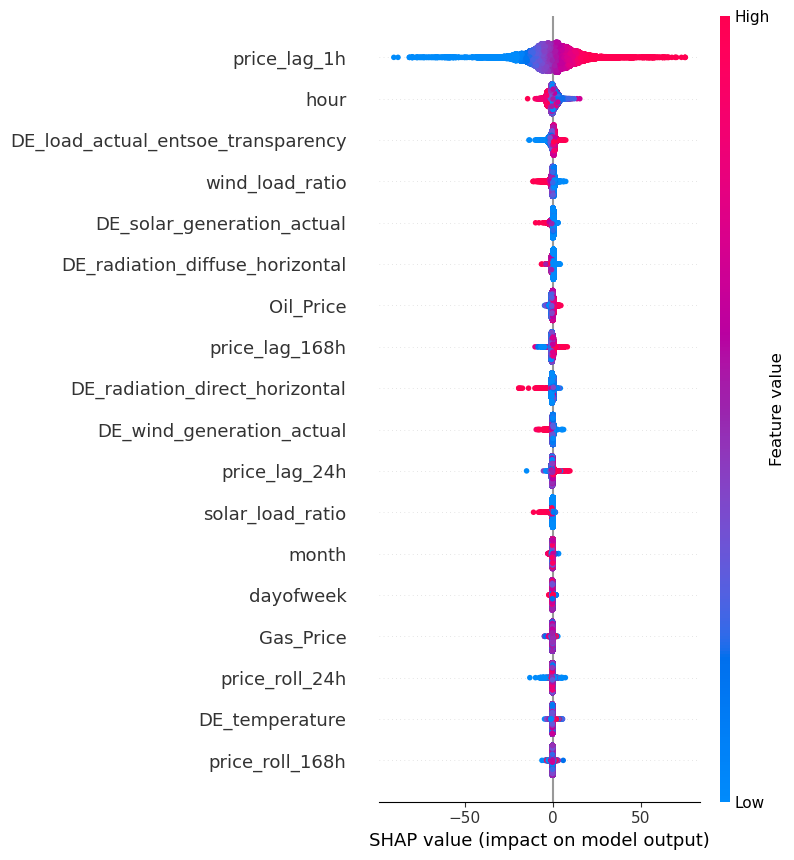

In [6]:
# Beeswarm plot (detailed value impact per feature)
shap.summary_plot(shap_values, X)

## 🔎 Local SHAP Explanation for a Single Prediction

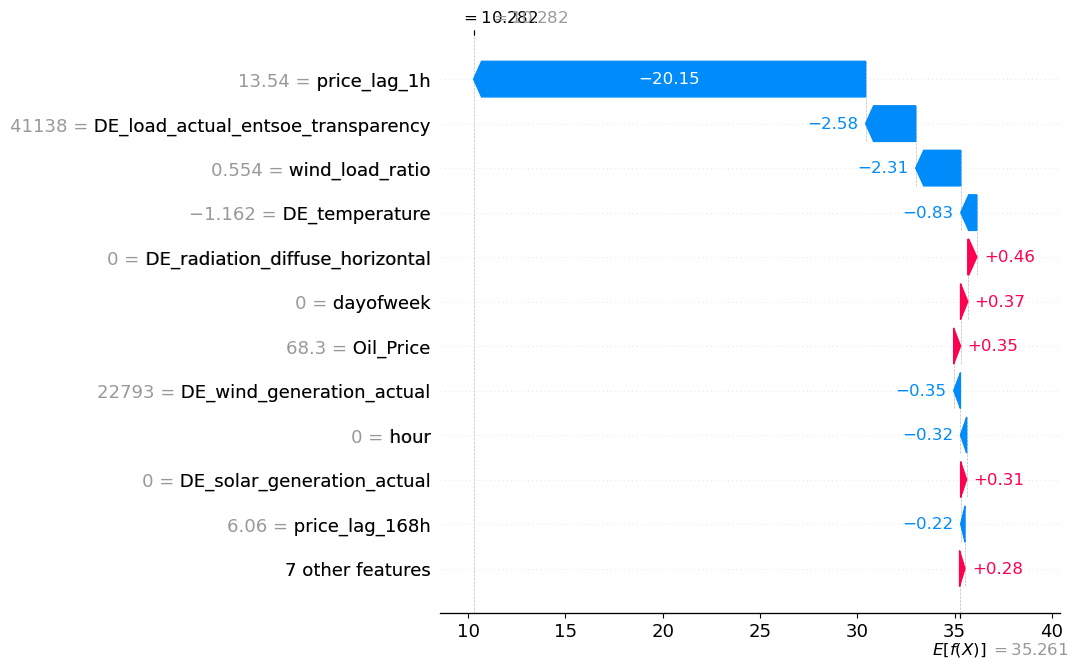

In [7]:
# Pick one row (e.g., latest)
i = -1  # last row
shap.plots.waterfall(shap_values[i], max_display=12)

Notebook to find most relavent features to know what too keep and what to discard for future modeling </br>
Finished by Jad Akra on April 20th 2025